**Assignment 3: Neural Networks**

**Note:** This assignment will not have auto-grading. Please fill directly this notebook and make sure to plot the results when it is asked. 

In this assignement we will construct a single-layer neural networks for binary classification of linearly unseparable data.

In [1]:
from sklearn import datasets  
import numpy as np  
import matplotlib.pyplot as plt

Dataset Generation
------------------

We randomly generate samples in dimension $p=2$.

In [2]:
n = 400
np.random.seed(0)  
XX, labels = datasets.make_moons(n,noise=.1)
YY = labels.reshape(n)

Display data points.

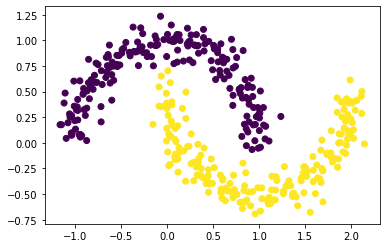

In [3]:
plt.scatter(XX[:,0], XX[:,1], c=YY)
plt.show()

Network Setup
--------------------

Let $m$ be the number of hidden units and $x$ the input. A neural network $\phi_W$ with one hidden layer operate by applying two successive dot products and non-linearities to compute an output $x_o = \phi_W(x)$, with $W=(W_h,W_o)$. The hidden variables are given by:

$$ \quad z_h= W_h (x,1), \quad x_h = \rho(z_h), \quad \mbox{ with } W_h \in \mathbb{R} ^{m \times (p+1)}. $$

The output $x_o$ can then be computed in the following way: 
$$ \quad z_o= W_o^T (x_h,1), \quad x_o = \rho(z_o), \quad \mbox{ with } W_o \in \mathbb{R} ^{p+1}. $$

The constant $1$ corresponds to the parameter of the bias term in the neural network. The function $\rho : \mathbb{R} \mapsto \mathbb{R} $ is called the nonlinearity.


The training is performed by minimizing the loss error between the predicted value $x_o = \phi_W(x)$ and the data (label) $y$:

$$ \min_{W} \mathbb{E}\Bigl( \frac{1}{2}\Bigl(y - \phi_W(x) \Bigl)^2 \Bigl). $$

Here, we use a least square error, but other choices such as logistic losses are possible.



Network nonlinearity
--------------------

1) Implement a (exponential) sigmoid function that will serve as the nonlinearity $\rho$ and its derivative $\rho'$



In [4]:
def rho(u): return 1/(1+(np.exp(-u))) 
def rho_derivative(u): return rho(u)*(1-rho(u))

Plot the activation.

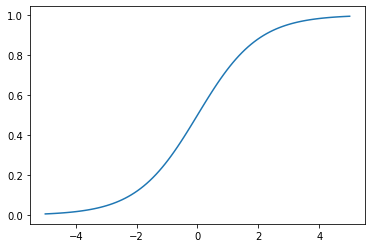

In [5]:
t = np.linspace(-5,5,100)
plt.plot(t, rho(t))

Network Evaluation
--------------------
2) Implement a function that evaluate the network for a given datapoint. This *foward pass* will be crucial for the computation of the gradient. 

In [6]:
def forwardpass(x,wh,wo):
    zh  = np.dot(wh,np.append(x,1))                      #Appending 1 to the input array as bias 
    xh = rho(zh)
    zo = np.dot(np.transpose(wo),np.append(xh,1))        #Appending 1 to the hidden layer output array as bias
    xo = rho(zo)
    return zh, xh, zo, xo

Network Optimization
--------------------

The network parameters are obtained by minimizing the empirical loss using gradient descent. For each datapoint $x$, the error is given by $\mathcal{E}(W)=\frac{1}{2} (y-x_o)^2$, with $x_o = \phi_W(x)$.

The gradient of this error is computed using the so-called backpropagation which uses the chain rule to compute the gradients of $\mathcal{E}$ with respct to $\nabla \mathcal{E}=(W_h,W _o)$:

$$ \frac{d \mathcal{E}}{d W_o} = \frac{d \mathcal{E}}{d x_o} \frac{d x_o}{d z_o} \frac{d z_o}{d W_o} $$


$$ \frac{d \mathcal{E}}{d W_h} = \frac{d \mathcal{E}}{d x_o} \frac{d x_o}{d z_o} \frac{d z_o}{d x_h}  \frac{d x_h}{d z_h}  \frac{d z_h}{d W_h}$$


3) Using these formulae, implement a function to perform the the backward pass through the network; i.e, computes these derivatives. 

In [7]:
def backwardpass(x,y,zh,xh,zo,xo,wo):
    dE_dxo = xo - y
    dxo_dzo = rho(zo)*(1-rho(zo))
    a = len(wo) 
    dzo_dxh = np.zeros(shape = wo.shape)
    dzo_dwo = np.zeros(shape = wo.shape)
    dzh_dwh = np.zeros(shape = wh.shape)
    for i in range(a):
      womul = np.copy(wo)
      xhmul = np.copy(np.append(xh,1))
      womul[i] = 1
      if i == a-1:
         xhmul[i] = 0 
      else:
        xhmul[i] = 0 
      dzo_dwo[i] = np.dot(np.transpose(womul),np.append(xh,1))
      dzo_dxh[i] = np.dot(np.transpose(wo),xhmul)
    c,d = wh.shape
    for i in range(c):
      for j in range(d):
        whmul = np.copy(wh)
        whmul[j] = 1
        dzh_dwh[i,j] = np.dot(whmul[i,:],np.append(x,1))
    dxh_dzh = rho(zh)*(1-rho(zh))
    dE_dwo = dE_dxo*dxo_dzo*dzo_dwo
    dE_dwh = np.transpose(dE_dxo * dxo_dzo * np.multiply(np.multiply(dzo_dxh[0:-1],dxh_dzh),np.transpose(dzh_dwh)))
    
    return dE_dwo, dE_dwh

Each step of a stochastic gradient descent consist in updating the parameters $W_h$ and $W_o$ by evaluating the loss on a randomly chosen datapoint. 

$$W^{k+1} = W^{k} - \ell*\nabla \mathcal{E},$$

where $\ell$ is the learning rate. 

4) Implement a function SGD that performs one step of gradient descent on a datapoint.


In [8]:
def SGD(wh,wo,dE_dwo,dE_dwh,rate):
    wh = np.subtract(wh, np.multiply(rate,dE_dwh))
    wo = np.subtract(wo , np.multiply(rate,dE_dwo))
    return wh,wo

Training
--------------------

Now, we want to run the SGD algorithm over our dataset in order to train the network. We will use $15$ units and a learning rate of $0.1$. 

5) Implement a script that performs the forward pass and backpropagation, then SGD over the data. In practice, it is better to make many passes over the data (more gradient steps than datapoints) in order to minmize the variance of the gradient error. Here, we use $2.10^5$ iterations. Copute the error every 1000 iterations and plot the loss error.

In [ ]:
m = 15
rate = .1
iter = 200000

wh = np.random.uniform(0,0.3,size = (m,p+1))
wo = np.random.uniform(0,0.3,size = m+1)

mult = 1000
Ero = list()
Erolab = list()
#labels = np.zeros(shape = (iter,len(YY)))
outs = np.zeros(shape = (iter,len(YY)))
for i in range(iter):
  for j in range(len(YY)):
    zh, xh, zo, xo = forwardpass(XX[j],wh,wo)
    dE_dwo, dE_dwh = backwardpass(XX[j],YY[j],zh,xh,zo,xo,wo)
    wh,wo =  SGD(wh,wo,dE_dwo,dE_dwh,rate)
    zh, xh, zo, xo = forwardpass(XX[j],wh,wo)
    outs[i,j] = xo
    #labels[i,j] 
  if i % mult == 0:                                                   #For every 1000 iterations, computing error and storing it 
    #Elab = np.sum(1/2*(np.subtract(YY,labels[i,:]))**2) / len(YY)
    #E = np.sum((1/2*(np.subtract(YY,outs[i,:]))**2) / len(YY))
    E = np.average(0.5*(np.subtract(YY,outs[i,:]))**2, axis =0)
    #Erolab.append(Elab)
    Ero.append(E)
    print('Error =', E)

Prediction
--------------------

6.1) Now that the network is trained, implement a function *prediction* that runs a foward pass on any input point and predict the label; i.e, labels it with the first class if the output $x_0$ is smaller than $1/2$ and the second class if the output $x_0$ is larger than $1/2$.

6.2) Generate a set of evaluation points on $\mathbb{ℝ}^p$ grid and test the results on the gridpoints. Plot the classification results.

In [ ]:
def prediction(x,wh,wo):
    zh, xh, zo, xo = forwardpass(x,wh,wo)
    if xo < 0.5: 
      label = 0
    else:
      label = 1
    return label 

In [ ]:
def generate_grid(xmin,xmax,ymin,ymax,ngrid):
    U = np.linspace(xmin,xmax,ngrid)
    V = np.linspace(ymin,ymax,ngrid)

    return U,V

In [ ]:
ngrid = 50
xmin = -1.5
xmax = 2.5
ymin =-1
ymax =2

lab = list()
U,V = generate_grid(xmin,xmax,ymin,ymax,ngrid)
plt.scatter(U, V)
for i in range(len(U)):
  x = [U[i],V[i]]
  p = prediction(x,wh,wo)
  lab.append(p)
  
plt.figure()
plt.scatter(U, V, c=lab)
plt.show()

Network Behaviour
--------------------

Now, we are going to look at the behaviour of such a network using a [ Neural Network playgroud](https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.62565&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false).


7) Use the input data two-cercles. Use a linear activation function and run the classification with different numbers of hidden layers and units. Comment the classification results and the behaviour of the test loss function. 

8) On the same data use now a ReLu activation function with $1$ hidden layer and $2$ neurons. Comment. Incease the number of hidden layers and keep the same number of neurons. Comment. What is the minimal number of neurons needed to model the hyperplan that seperate the data using ReLu.

9) Once you a minimum number of hidden layers and neurons is found for the classification, comment on the effect of adding more neuron and layers in terms of computation time and loss error variance.



Answers:
--------------------

Answer 7:

Answer 8:

Answer 9: